# Training a Convolutional Neural Network to perform a classification task on the CIFAR10 data set

## |1|Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

## |2|Load and preprocess the CIFAR-10 dataset

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## |3|Define the labels of the dataset

In [4]:
original_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
binary_labels = ['cannot fly', 'can fly']

## Convert labels to binary classes

In [6]:
y_train_binary = np.where(np.isin(y_train, [0, 2]), 1, 0)
y_test_binary = np.where(np.isin(y_test, [0, 2]), 1, 0)

## Let's view more images in a grid format

<ipython-input-7-e2d0580ec5f7>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train_binary[index])


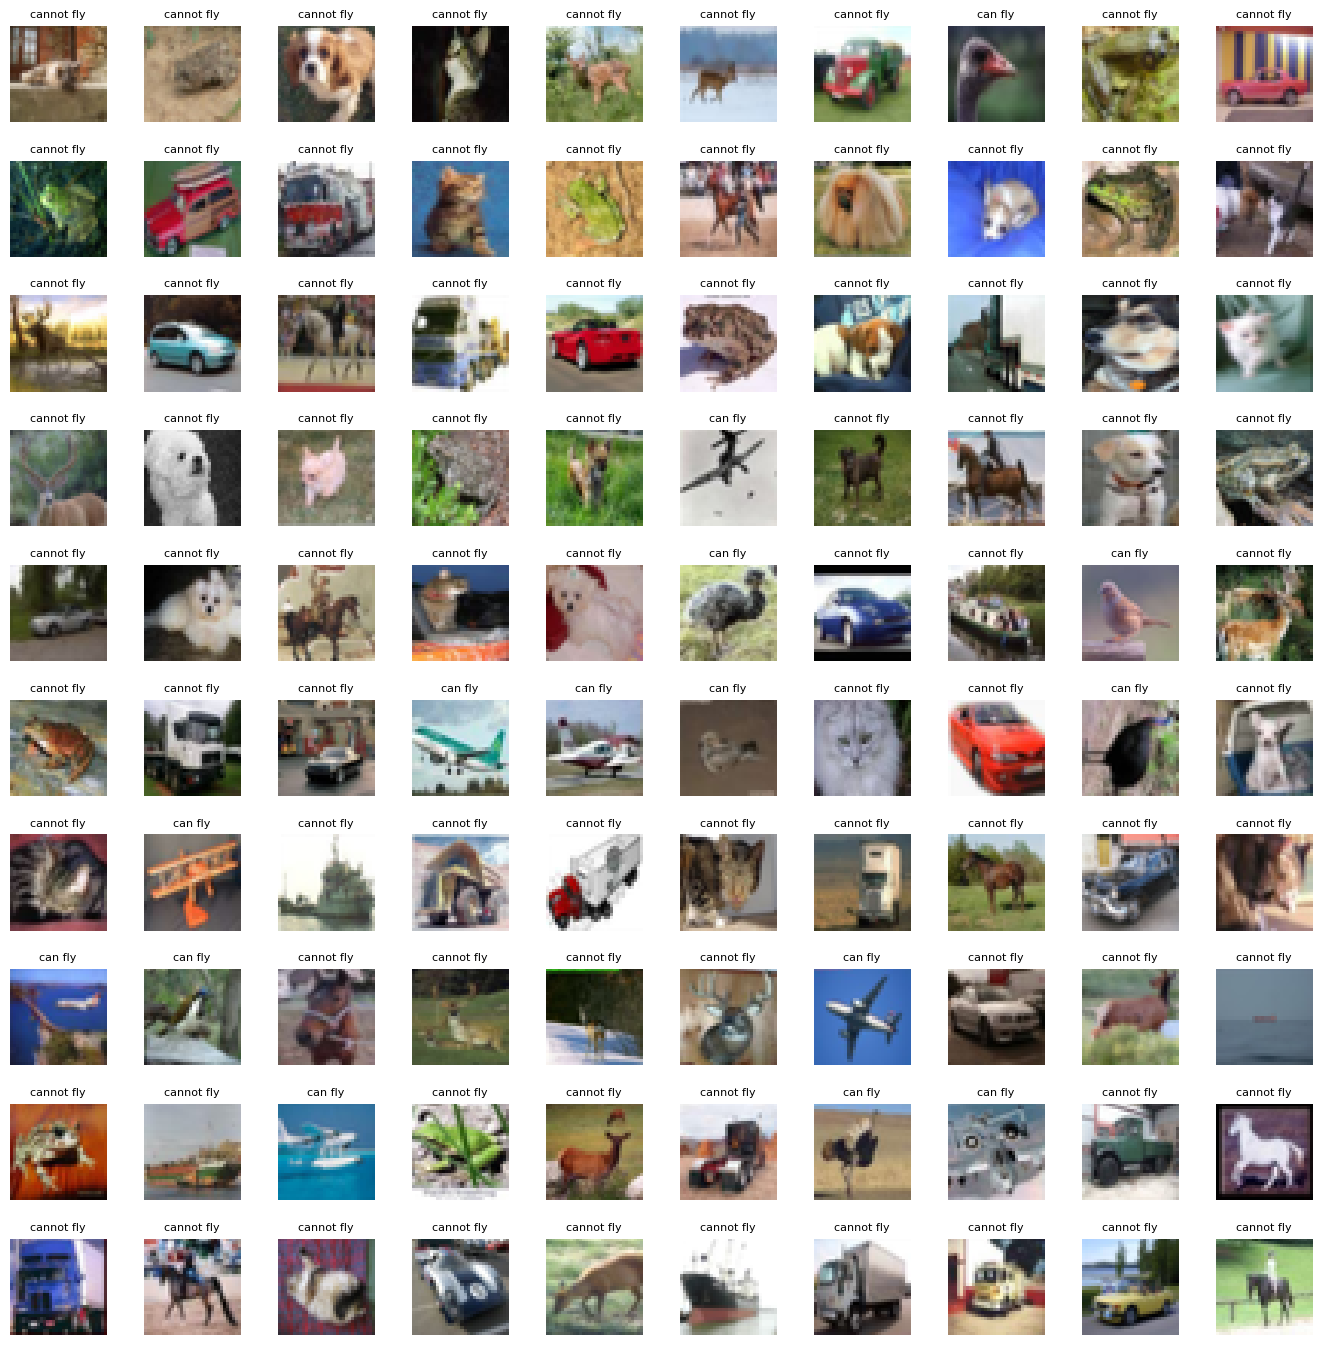

In [7]:
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(17,17))
axes = axes.ravel()

n_train = len(X_train)
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index])
    label_index = int(y_train_binary[index])
    axes[i].set_title(binary_labels[label_index], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## Class disctribution in training set

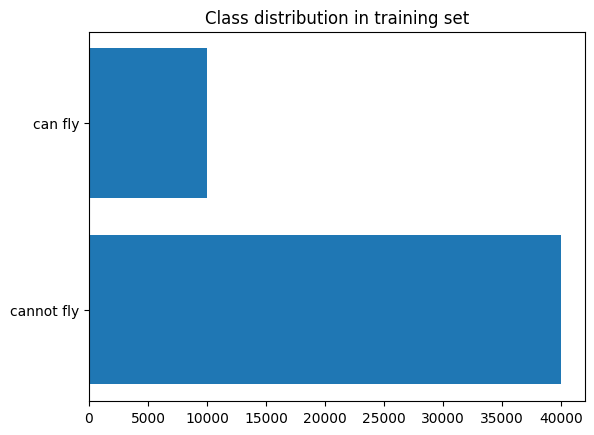

In [8]:
classes, counts = np.unique(y_train_binary, return_counts=True)
plt.barh(binary_labels, counts)
plt.title('Class distribution in training set')
plt.show()

## Class disctribution in testing set

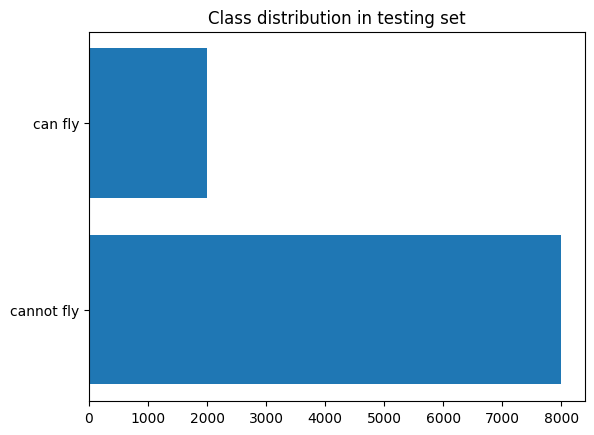

In [9]:
classes, counts = np.unique(y_test_binary, return_counts=True)
plt.barh(binary_labels, counts)
plt.title('Class distribution in testing set')
plt.show()

## Scale the data

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Transform target variable into one-hotencoding

In [11]:
y_cat_train = to_categorical(y_train_binary, 2)
y_cat_test = to_categorical(y_test_binary, 2)

## Model definition

In [12]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

## Convolutional layers

In [13]:
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

## Compile the model

In [14]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

## Early stopping

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

## Data augmentation

In [16]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

## Train the model

In [17]:
r = model.fit(train_generator,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
              callbacks=[early_stop],
             )

Epoch 1/50
1562/1562 [==============================] - 456s 289ms/step - loss: 0.4182 - accuracy: 0.8293 - precision: 0.8293 - recall: 0.8293 - val_loss: 0.4657 - val_accuracy: 0.8336 - val_precision: 0.8336 - val_recall: 0.8336
Epoch 2/50
1562/1562 [==============================] - 438s 280ms/step - loss: 0.3407 - accuracy: 0.8609 - precision: 0.8609 - recall: 0.8609 - val_loss: 0.4126 - val_accuracy: 0.8383 - val_precision: 0.8383 - val_recall: 0.8383
Epoch 3/50
1562/1562 [==============================] - 431s 276ms/step - loss: 0.3044 - accuracy: 0.8773 - precision: 0.8773 - recall: 0.8773 - val_loss: 0.3995 - val_accuracy: 0.8209 - val_precision: 0.8209 - val_recall: 0.8209
Epoch 4/50
1562/1562 [==============================] - 432s 277ms/step - loss: 0.2828 - accuracy: 0.8872 - precision: 0.8872 - recall: 0.8872 - val_loss: 0.3295 - val_accuracy: 0.8867 - val_precision: 0.8867 - val_recall: 0.8867
Epoch 5/50
1562/1562 [==============================] - 459s 293ms/step - loss: 

# Plot training & validation accuracy and loss

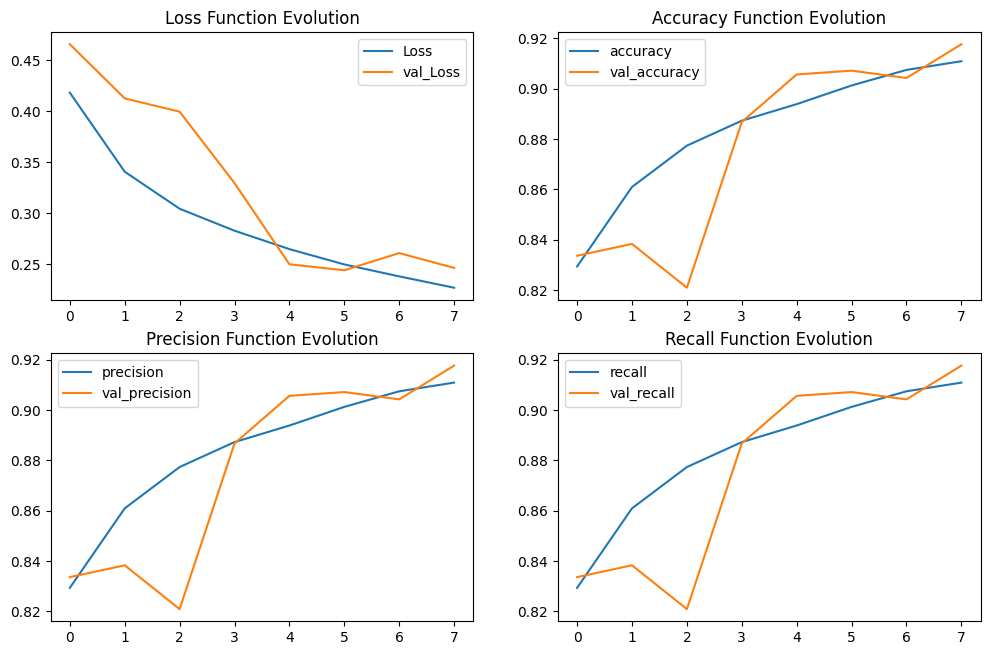

In [18]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

plt.show()

# Evaluate the model

In [19]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 20s 64ms/step - loss: 0.2463 - accuracy: 0.9176 - precision: 0.9176 - recall: 0.9176
Test Accuracy : 91.76%


## Confusion matrix and classification report

313/313 [==============================] - 26s 83ms/step


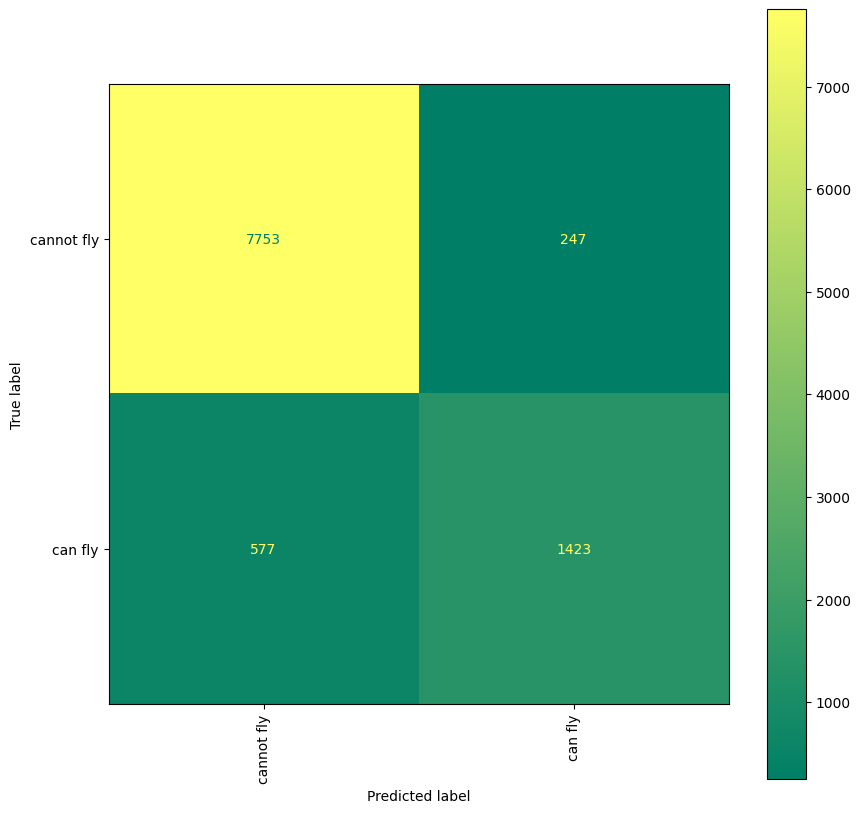

              precision    recall  f1-score   support

  cannot fly       0.93      0.97      0.95      8000
     can fly       0.85      0.71      0.78      2000

    accuracy                           0.92     10000
   macro avg       0.89      0.84      0.86     10000
weighted avg       0.92      0.92      0.91     10000



In [20]:
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_binary, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')
plt.show()

print(classification_report(y_test_binary, y_pred_binary, target_names=binary_labels))


## Display predictions

313/313 [==============================] - 21s 66ms/step


<ipython-input-21-3e8f9f2e857f>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(f"{binary_labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({binary_labels[int(true_label)]})",
<ipython-input-21-3e8f9f2e857f>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions_array, true_label = predictions_array, int(true_label[i])


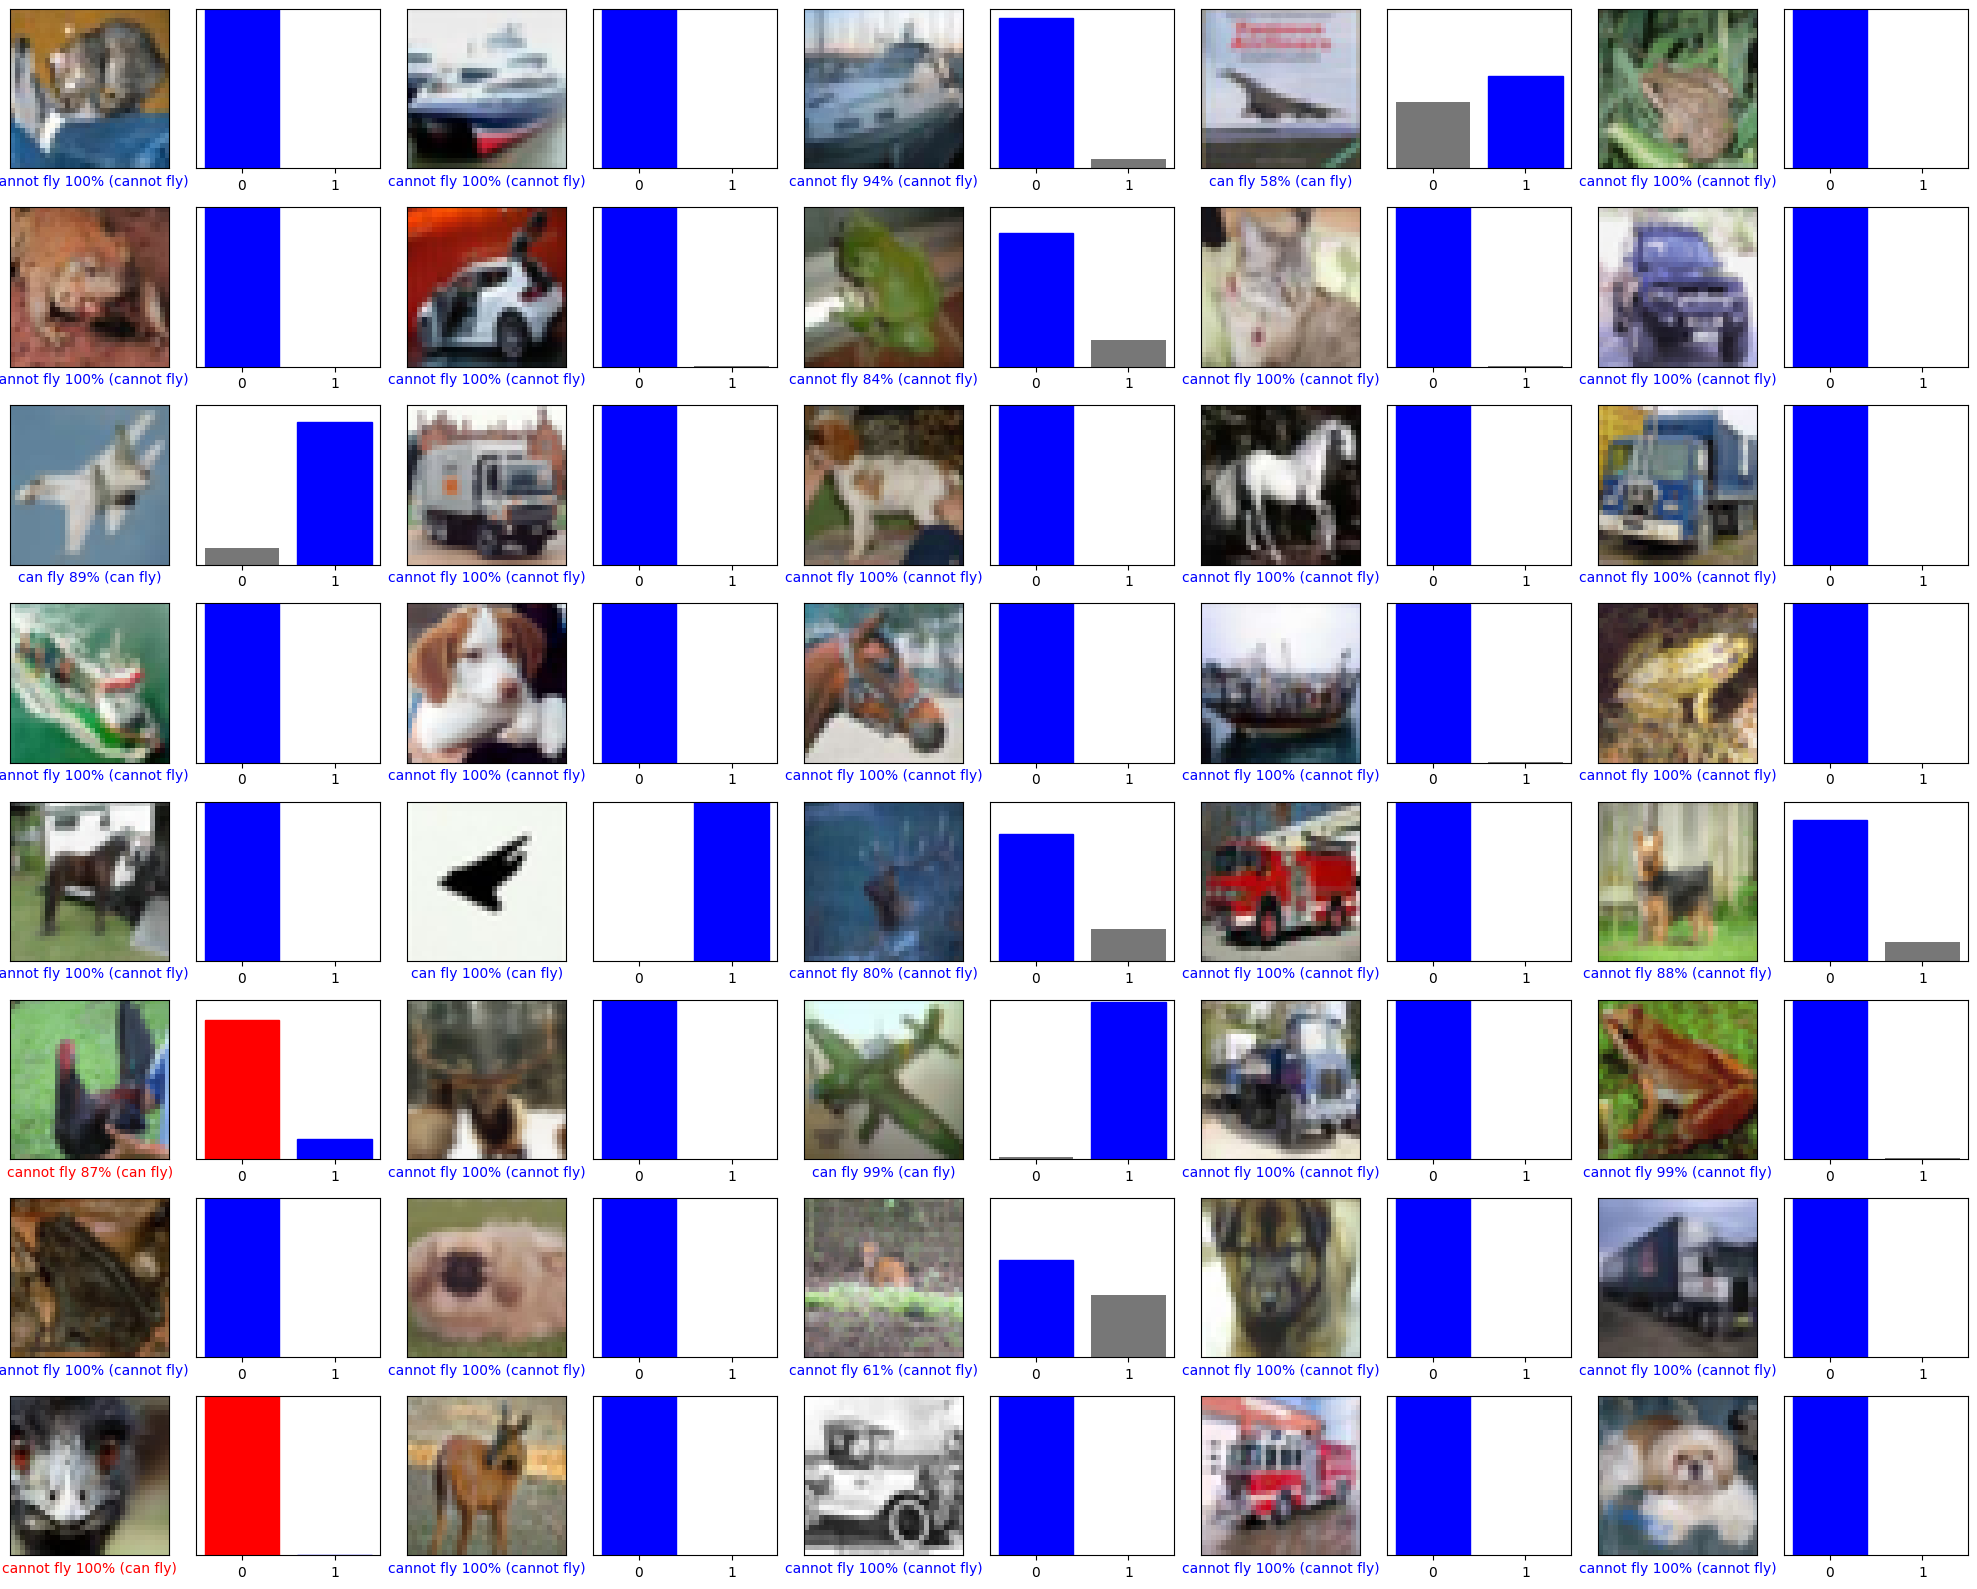

In [21]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{binary_labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({binary_labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

predictions = model.predict(X_test)

num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test_binary, X_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], y_test_binary)
plt.tight_layout()
plt.show()

In [22]:
model.save('cnn_20_epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
